In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import os

# Config
stations = [101, 102, 103, 104]
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 3, 31)
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Save path
save_path = "C:/Users/91976/Desktop/ChargingAccessibility/data/simulated_ev_demand.csv"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Season mapper
def get_season(month):
    return {12: 'Summer', 1: 'Summer', 2: 'Summer',
            3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
            6: 'Winter', 7: 'Winter', 8: 'Winter',
            9: 'Spring', 10: 'Spring', 11: 'Spring'}[month]

# Generate data
data = []
for station_id in stations:
    for ts in timestamps:
        base_demand = random.randint(10, 30)
        fluctuation = 5 * np.sin(2 * np.pi * ts.hour / 24) + random.randint(-3, 3)
        traffic = random.choices(['Low', 'Medium', 'High'], weights=[0.3, 0.5, 0.2])[0]
        weather_main = random.choice(['Clear', 'Rain', 'Clouds', 'Fog'])
        temp = random.uniform(15, 35)
        humidity = random.randint(30, 80)
        wind_speed = random.uniform(1, 7)

        data.append({
            "timestamp": ts,
            "station_id": station_id,
            "current_demand": max(0, int(base_demand + fluctuation)),
            "temperature": round(temp, 1),
            "humidity": humidity,
            "wind_speed": round(wind_speed, 1),
            "traffic_density": traffic,
            "is_holiday": ts.weekday() >= 5,
            "day_of_week": ts.strftime('%A'),
            "hour_of_day": ts.hour,
            "season": get_season(ts.month),
            "weather_main": weather_main
        })

# Create DataFrame and save
df = pd.DataFrame(data)
df.to_csv(save_path, index=False)
print(f"✅ Dataset saved to: {save_path}")


✅ Dataset saved to: C:/Users/91976/Desktop/ChargingAccessibility/data/simulated_ev_demand.csv


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Users/91976/Desktop/ChargingAccessibility/data/simulated_ev_demand.csv", parse_dates=["timestamp"])

# Sort for time series operations
df = df.sort_values(by=["station_id", "timestamp"])

# ------------------ 1. Create Lag Features ------------------
# Lag features for demand (1-hour and 2-hour before)
df["lag_demand_1h"] = df.groupby("station_id")["current_demand"].shift(1)
df["lag_demand_2h"] = df.groupby("station_id")["current_demand"].shift(2)

# ------------------ 2. Time-Based Pattern Features ------------------
# These already exist, but if needed, regenerate them
df["hour_of_day"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()
df["season"] = df["timestamp"].dt.month.map({
    12: 'Summer', 1: 'Summer', 2: 'Summer',
    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
    6: 'Winter', 7: 'Winter', 8: 'Winter',
    9: 'Spring', 10: 'Spring', 11: 'Spring'
})

# Encode day of week as numeric (for modeling)
df["day_of_week_num"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6

# ------------------ 3. Encode Categorical Features ------------------
# One-hot encode 'weather_main', 'traffic_density', and 'season'
df = pd.get_dummies(df, columns=["weather_main", "traffic_density", "season"], prefix_sep="_")

# ------------------ 4. Aggregate Demand Per Charger ------------------
# Total demand seen by each station over time
agg_demand = df.groupby("station_id")["current_demand"].sum().reset_index()
agg_demand.columns = ["station_id", "total_demand"]

# Merge into main dataframe
df = df.merge(agg_demand, on="station_id", how="left")

# ------------------ Save Engineered Dataset ------------------
output_path = "C:/Users/91976/Desktop/ChargingAccessibility/data/engineered_ev_demand.csv"
df.to_csv(output_path, index=False)
print(f"✅ Feature-engineered dataset saved to: {output_path}")


✅ Feature-engineered dataset saved to: C:/Users/91976/Desktop/ChargingAccessibility/data/engineered_ev_demand.csv


In [5]:
import pandas as pd

df = pd.read_csv("C:/Users/91976/Desktop/ChargingAccessibility/data/engineered_ev_demand.csv", parse_dates=["timestamp"])


C:\Users\91976\AppData\Local\Temp\ipykernel_34560\3664202827.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = station_df.set_index("timestamp")["current_demand"].asfreq("H").fillna(method="ffill")


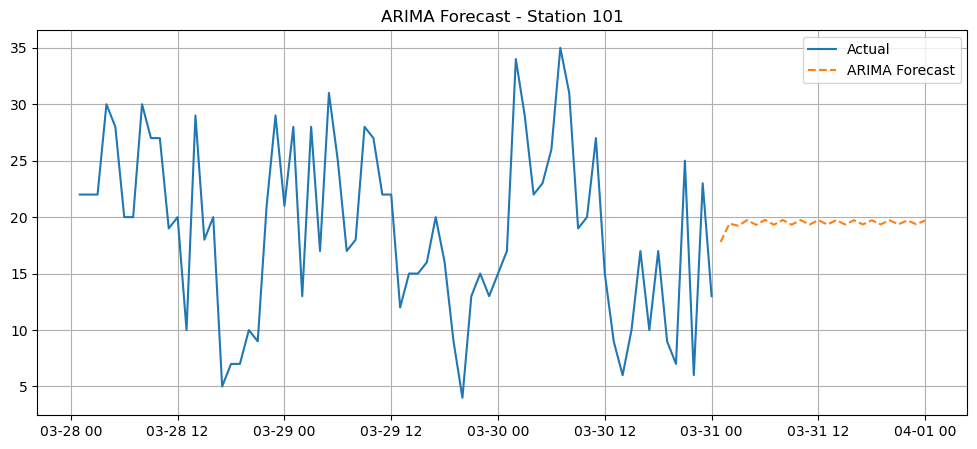

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Choose one station
station_id = 101
station_df = df[df["station_id"] == station_id].sort_values("timestamp")

# Ensure no gaps in time
ts = station_df.set_index("timestamp")["current_demand"].asfreq("H").fillna(method="ffill")

# Fit ARIMA
model = ARIMA(ts, order=(2, 1, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=24)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts[-72:], label="Actual")
plt.plot(forecast.index, forecast, label="ARIMA Forecast", linestyle='--')
plt.legend()
plt.title(f"ARIMA Forecast - Station {station_id}")
plt.grid()
plt.show()


10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing


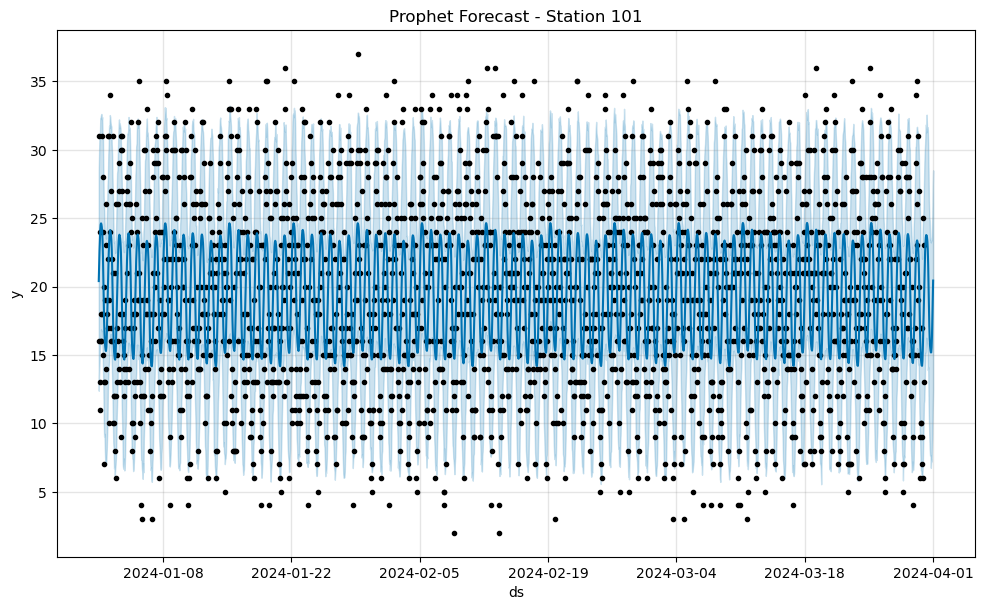

In [7]:
from prophet import Prophet

prophet_df = station_df[["timestamp", "current_demand"]].rename(columns={"timestamp": "ds", "current_demand": "y"})
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

model.plot(forecast)
plt.title(f"Prophet Forecast - Station {station_id}")
plt.show()


In [8]:
!pip install tensorflow


In [15]:
# import numpy as np
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# from sklearn.preprocessing import MinMaxScaler

# features = ["current_demand", "lag_demand_1h", "lag_demand_2h", "temperature", "humidity", "wind_speed", "hour_of_day"]
# station_data = station_df[features].dropna()

# # Normalize
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(station_data)

# # Sequence creation
# X, y = [], []
# seq_len = 24
# for i in range(len(scaled) - seq_len):
#     X.append(scaled[i:i+seq_len])
#     y.append(scaled[i+seq_len][0])
# X, y = np.array(X), np.array(y)

# # Train LSTM
# model = Sequential()
# model.add(LSTM(64, input_shape=(seq_len, X.shape[2])))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# model.fit(X, y, epochs=10, batch_size=32)

# # Forecast next 24 steps
# preds = []
# current_seq = X[-1]
# for _ in range(24):
#     pred = model.predict(current_seq[np.newaxis], verbose=0)[0, 0]
#     preds.append(pred)
#     next_input = np.append(current_seq[1:], [[pred] + list(current_seq[-1][1:])], axis=0)
#     current_seq = next_input

# # Inverse transform
# padded = np.hstack([np.array(preds).reshape(-1, 1), np.zeros((24, scaled.shape[1] - 1))])
# forecast_lstm = scaler.inverse_transform(padded)[:, 0]

# # Plot
# plt.plot(station_data["current_demand"].values[-72:], label="Actual")
# plt.plot(np.arange(len(station_data), len(station_data) + 24), forecast_lstm, label="LSTM Forecast", linestyle="--")
# plt.legend()
# plt.title(f"LSTM Forecast - Station {station_id}")
# plt.show()


ImportError: Traceback (most recent call last):
  File "C:\Users\91976\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.